In [1]:
from pyrates import CircuitTemplate
from pycobi import ODESystem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# change to False, if you are not using dark mode
dark_mode = True

# adapts matplotlib color settings to work with dark mode
if dark_mode:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white' 
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['legend.facecolor'] = 'black'

- equations of QIF neuron and QIF mean-field model with SFA
- parameter continuation for QIF mean-field model with low SFA
- Fold curve continuation in 2D parameter space
- parameter continuation for QIF mean-field model with high SFA
- Limit cycle continuation
- Hopf curve continuation in 2D parameter space
- example simulations

# Numerical Bifurcation Analysis

<br/>

In this notebook, you will apply methods such as numerical parameter continuation and automated bifurcation analysis via a high-level interface to Auto-07p.
We will continue to work with the Izhikevich neuron as an example model, but study bifurcations at the network level, rather than the single-neuron level.

<br/>

## Mean-field equations for Spiking Neural Networks

<br/>

In the previous notebook, we studied networks of coupled spiking neurons.
Due to the discontinuity around the spike (due to the resetting mechanism), we cannot study these networks via tools from bifurcation analysis.

This is why, in this part, we study mean-field equations of the network dynamics instead.
We have learned already that network-wide quantities such as the average membrane potential are the crucial information carrying variables when it comes to the dynamic state that the entire network is in.
Mean-field equations provide the means to study these network-wide quantities directly.
They are continous-valued models that have been derived from the spiking neural network equations.
This relationship is depicted below:

<img src="img/neco_micro_macro.png" width="800">

The particular set of mean-field equations for networks of coupled Izhikevich neurons that we will study is provided below:

$$ C \dot{r} = \frac{\Delta_v k^2 \sigma_v}{\pi C} (v-v_r) + r[k(2 v - v_r - \bar v_{\theta}) - g s],$$
$$ C \dot{v} = k v(v -v_r-\bar v_{\theta}) - \pi C r(\Delta_v \sigma_v + \frac{\pi C}{k} r) + k v_r \bar v_{\theta} - u + I  + g s (E-v), $$
$$ \tau_u \dot{u} = b(v-v_r) - u + \tau_u \kappa r, $$
$$ \tau_s \dot{s} = -s + \tau_s J r. $$

For more information on how these mean-field equations can be derived from the network equations of coupled Izhikevich neurons, see [this paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.107.024306).
Importantly, these four coupled differential equations approximatively capture the dynamics of the average firing rate $r$, the average membrane potential $v$, the average recovery variable $u$, and the global synaptic input $s$ of an Izhikevich neural network with distributed spike thresholds $v_t$.

It is this set of equations and its parameter dependencies that we will study via bifurcation analysis below.

## Parameter Continuations via PyCoBi

To study how the equilibrium structure of the mean-field equations changes as a function of one of its parameter, we can use [numerical continuation](https://en.wikipedia.org/wiki/Numerical_continuation).

<br/>

However, as a first step, we have to find a stable solution of the system dynamics.
Every numerical continuation algorithm requires a stable solution for a particular choice of the parameter.
Based on this initial solution, the algorithm can then detect how small changes in the parameter translate to changes in the stable solution.

<br/>

Let's find such a solution via a numerical simulation for a particular parameter set of our mean-field equations.
To this end, we use the pre-implemented mean-field equations in the dynamical systems modeling tool [PyRates](https://github.com/pyrates-neuroscience/PyRates).

<br/>

Let's run the cell below to perform the simulation and observe whether the model converged to a stable solution.

In [8]:
from pyrates import CircuitTemplate

# initialize mean-field model
ik_mf = CircuitTemplate.from_yaml("model_templates.neural_mass_models.ik.ik_theta")

# set the initial value of all model parameters
mf_params = {"C": 100.0, "k": 0.7, "v_r": -60.0, "v_t": -40.0, "b": -2.0, "g": 15.0,
             "a": 0.03, "d": 100.0, "tau_s": 6.0, "E_r": 0.0, "eta": 70.0}
ik_mf.update_var(node_vars={f"p/ik_theta_op/{key}": val for key, val in mf_params.items()})

# define simulation parameters (time unit: ms)
T = 1000.0
dt = 1e-2
sr = 100

# perform mean-field simulation
res = ik_mf.run(simulation_time=T, step_size=dt, sampling_step_size=int(dt*sr), 
                outputs={"v": "p/ik_theta_op/v", "r": "p/ik_theta_op/r"}, 
                in_place=False)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 2.3141656999999896s.


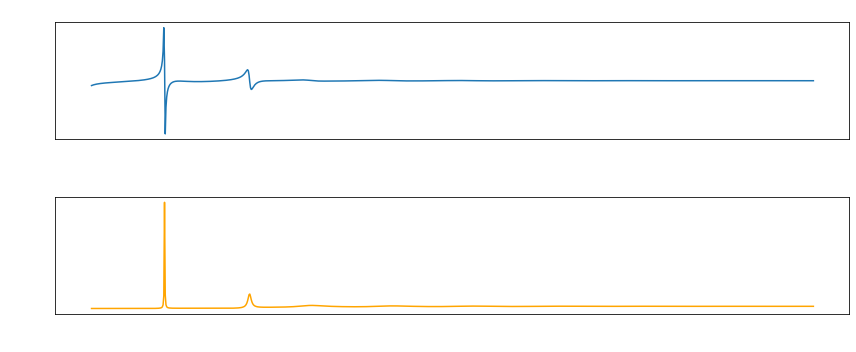

In [9]:
# plot results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
ax = axes[0]
ax.plot(res["v"])
ax.set_xlabel("time (ms)")
ax.set_ylabel("v (mV)")
ax.set_title("Average membrane potential dynamics")
ax = axes[1]
ax.plot(res["r"]*1e3, color="orange")
ax.set_xlabel("time (ms)")
ax.set_ylabel("r (1/s)")
ax.set_title("Average firing rate dynamics")
plt.tight_layout()

As we can see from the dynamics in the two state variables $v$ and $r$, the model seems to have converged to a stable state after initial fluctuations.
We can thus use the value of the state variables at the end of this simulation for parameter continuations.

<br/>

To perform parameter continuations as well as automated bifurcation analysis, we will use the software [PyCoBi](https://github.com/pyrates-neuroscience/PyCoBi), which is a Python wrapper to the Fortran software [Auto-07p](https://github.com/auto-07p/auto-07p). 
We can create a simple instance of the main PyCoBi class for parameter continuations and bifurcation analysis via the following line:

In [ ]:
cont = ODESystem(working_dir=None, auto_dir=auto_dir, init_cont=False)

To run parameter continuations, PyCoBi will require user-supplied Fortran files that contain the model equations, parameters, and meta parameters for Auto-07p.
Don't worry, you wont have to write Fortran code yourself.

<br/>

PyRates provides a simple function call, which creates all necessary Fortran user files and writes them to a file in your working directory.
It will automatically use the lates values of all state variables and model parameters and thus make use of the stable state solution we just found. 

In [ ]:
ik_mf.get_run_func(func_name='ik_rhs', file_name='ik', step_size=dt, auto=True, 
                   backend='fortran', solver='scipy', vectorize=False, 
                   float_precision='float64')

Let's have a look at the file that was created. We will need to know the positions of state variables and parameters in their respective vectors:

In [12]:
f = open('ik.f90', 'r')
print('')
print(f.read())


module ik

double precision :: PI = 4.0*atan(1.0)

contains


subroutine ik_rhs(t,y,dy,v_t,v_r,k,g,Delta,C,E_r,I_ext,eta,b,a,d,tau_s)

implicit none

double precision, intent(in) :: t
double precision, intent(in) :: y(4)
double precision :: r
double precision :: v
double precision :: u
double precision :: s
double precision :: r_in
double precision, intent(inout) :: dy(4)
double precision, intent(in) :: v_t
double precision, intent(in) :: v_r
double precision, intent(in) :: k
double precision, intent(in) :: g
double precision, intent(in) :: Delta
double precision, intent(in) :: C
double precision, intent(in) :: E_r
double precision, intent(in) :: I_ext
double precision, intent(in) :: eta
double precision, intent(in) :: b
double precision, intent(in) :: a
double precision, intent(in) :: d
double precision, intent(in) :: tau_s


r = y(1)
v = y(2)
u = y(3)
s = y(4)
r_in = r

dy(1) = (r*(-g*s + k*(2.0*v - v_r - v_t)) + Delta*k**2*(v - v_r)&
     & /(pi*C))/C
dy(2) = (-pi*C*r*(pi*C*r/k &
 

Now we are ready to run parameter continuations via PyCoBi.

<br/>

### (I) Continuation of a known steady-state solution in one parameter

<br/>

As a first example, we will continue the solution that we obtained above in the parameter $\eta$, which can be viewed as a background input.
In order to r